# Data Preprocessing: Titanic-Spaceship <span style="color:orange">**Competition**</span>
<img src="../assets/spaceship-pic.jpg" alt="Title-Pic">

# Imports

In [430]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import Series, DataFrame
from numpy.random import choice
from xgboost import XGBClassifier
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


np.set_printoptions(suppress=True)
sns.set(rc={"figure.figsize": (12, 7), "axes.titlesize": 20, "axes.titleweight": "bold", "axes.labelsize": 15})

In [354]:
import warnings
warnings.filterwarnings('ignore')

# Data

In [355]:
df_train = pd.read_csv("../data/data.csv")
df_test = pd.read_csv("../data/test.csv")
df_train.shape, df_test.shape

((8693, 14), (4277, 13))

In [356]:
# (its a competition)
df = pd.concat([df_train, df_test])
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN


# Helper Functions & Constants

In [357]:
# Columns
PID = "PassengerId"
HOME_PLANET = "HomePlanet"
CRYO_SLEEP = "CryoSleep"
CABIN = "Cabin"
DESTINATION = "Destination"
AGE = "Age"
VIP = "VIP"
ROOM_SERVICE = "RoomService"
FOOD_COURT = "FoodCourt"
SHOPPING_MALL = "ShoppingMall"
SPA = "Spa"
VR_DECK = "VRDeck"
NAME = "Name"
TRANSPORTED = "Transported"

# Constants
TARGET = "Target"
PAYMENTS = "Payments"

# maps
TRUE_FALSE_MAP = {False: 0, True: 1}

# Data Preprocessing

## First Overview

In [362]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.5+ MB


In [363]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [364]:
df.describe(include=["O"])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported
count,12970,12682,12660,12671,12696,12674,12676,8693
unique,12970,3,2,9825,3,2,12629,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Carry Contrevins,True
freq,1,6865,8079,8,8871,12401,2,4378


## Drop Features

In [365]:
df.drop(columns=[NAME], inplace=True)
df.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True


## Target | Transported

In [366]:
df.rename(columns={TRANSPORTED: TARGET}, inplace=True)
df.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Target
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True


In [367]:
df[TARGET].value_counts(dropna=False)

True     4378
False    4315
NaN      4277
Name: Target, dtype: int64

In [368]:
df.loc[~df[TARGET].isna(), TARGET] = df.loc[~df[TARGET].isna(), TARGET].map(TRUE_FALSE_MAP).astype("int")
df[TARGET].value_counts(dropna=False)

1.0    4378
0.0    4315
NaN    4277
Name: Target, dtype: int64

## General Preprocessing

In [369]:
df[CRYO_SLEEP] = df[CRYO_SLEEP].map(TRUE_FALSE_MAP)
df[VIP] = df[VIP].map(TRUE_FALSE_MAP)

display(
    df[CRYO_SLEEP].value_counts(dropna=False),
    df[VIP].value_counts(dropna=False)
)

0.0    8079
1.0    4581
NaN     310
Name: CryoSleep, dtype: int64

0.0    12401
NaN      296
1.0      273
Name: VIP, dtype: int64

In [370]:
df[CABIN] = df[CABIN].str[0]
df[CABIN].value_counts(dropna=False)

F      4239
G      3781
E      1323
B      1141
C      1102
D       720
A       354
NaN     299
T        11
Name: Cabin, dtype: int64

In [371]:
def set_payments_to_zero(column_name):
    df.loc[df[column_name].isna(), column_name] = 0
    
set_payments_to_zero(ROOM_SERVICE)
set_payments_to_zero(FOOD_COURT)
set_payments_to_zero(SHOPPING_MALL)
set_payments_to_zero(SPA)
set_payments_to_zero(VR_DECK)

df.isna().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Target          4277
dtype: int64

## HomePlanet

In [372]:
df[HOME_PLANET].isna().sum()

288

In [373]:
display(
    df.loc[df[HOME_PLANET] == "Earth", [FOOD_COURT, SPA, VR_DECK]].quantile(q=[0.8]),
    df.loc[df[HOME_PLANET] == "Mars", [FOOD_COURT, SPA, VR_DECK]].quantile(q=[0.8]),
    df.loc[df[HOME_PLANET] == "Europa", [FOOD_COURT, SPA, VR_DECK]].quantile(q=[0.8])
)

,FoodCourt,Spa,VRDeck
0.8,104.2,95.2,91.0


,FoodCourt,Spa,VRDeck
0.8,0.0,14.4,0.0


,FoodCourt,Spa,VRDeck
0.8,2506.0,1016.4,1103.4


In [374]:
europa_condition1 = (
    (df[HOME_PLANET].isna()) & 
    (
        (df[FOOD_COURT] > 105) | 
        (df[SPA] > 105) | 
        (df[VR_DECK] > 105)
    )
)
df.loc[europa_condition1, HOME_PLANET] = "Europa" 
df[df[HOME_PLANET].isna()].shape

(165, 13)

In [375]:
display(
    df.loc[df[HOME_PLANET] == "Earth", [SHOPPING_MALL, ROOM_SERVICE]].quantile(q=[0.8]),
    df.loc[df[HOME_PLANET] == "Mars", [SHOPPING_MALL, ROOM_SERVICE]].quantile(q=[0.8]),
    df.loc[df[HOME_PLANET] == "Europa", [SHOPPING_MALL, ROOM_SERVICE]].quantile(q=[0.8])
)

,ShoppingMall,RoomService
0.8,85.0,95.2


,ShoppingMall,RoomService
0.8,529.2,1044.4


,ShoppingMall,RoomService
0.8,0.0,0.0


In [376]:
mars_condition1 = (
    (df[HOME_PLANET].isna()) & 
    (
        (df[SHOPPING_MALL] > 100) | 
        (df[ROOM_SERVICE] > 105)
    )
)
df.loc[mars_condition1, HOME_PLANET] = "Mars" 
df[df[HOME_PLANET].isna()].shape

(119, 13)

In [377]:
df.loc[(df[HOME_PLANET].isna()) & (df[TARGET] == 1), HOME_PLANET] = "Europa"
df[df[HOME_PLANET].isna()].shape

(48, 13)

In [378]:
df[df[HOME_PLANET].isna()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Target
1550,1645_01,NaN,1.0,NaN,55 Cancri e,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1757,1865_06,NaN,0.0,G,TRAPPIST-1e,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1807,1926_01,NaN,1.0,G,TRAPPIST-1e,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2166,2312_01,NaN,1.0,G,TRAPPIST-1e,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2173,2319_01,NaN,1.0,G,PSO J318.5-22,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2281,2451_01,NaN,1.0,G,PSO J318.5-22,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2290,2461_01,NaN,1.0,G,TRAPPIST-1e,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2642,2822_05,NaN,1.0,G,TRAPPIST-1e,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3370,3624_01,NaN,0.0,G,TRAPPIST-1e,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3816,4078_01,NaN,1.0,G,TRAPPIST-1e,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [379]:
df.loc[(df[HOME_PLANET].isna()) & (df[CABIN].isin(["G", "F"])), HOME_PLANET] = "Earth"
df[df[HOME_PLANET].isna()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Target
1550,1645_01,NaN,1.0,NaN,55 Cancri e,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0
535,1124_02,NaN,1.0,C,TRAPPIST-1e,22.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1063,2245_01,NaN,1.0,A,55 Cancri e,43.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1335,2855_01,NaN,1.0,D,55 Cancri e,50.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1545,3341_01,NaN,1.0,C,55 Cancri e,19.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1569,3368_05,NaN,1.0,E,TRAPPIST-1e,47.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2141,4639_05,NaN,1.0,C,TRAPPIST-1e,33.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2822,6240_01,NaN,1.0,E,TRAPPIST-1e,49.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3093,6781_01,NaN,1.0,A,55 Cancri e,59.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3220,7065_01,NaN,1.0,E,TRAPPIST-1e,28.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [380]:
df.loc[(df[HOME_PLANET].isna()) & (df[CABIN].isin(["C", "A"])), HOME_PLANET] = "Europa"
df.loc[(df[HOME_PLANET].isna()) & (df[CABIN].isin(["D"])), HOME_PLANET] = "Mars"
df[df[HOME_PLANET].isna()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Target
1550,1645_01,NaN,1.0,NaN,55 Cancri e,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1569,3368_05,NaN,1.0,E,TRAPPIST-1e,47.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2822,6240_01,NaN,1.0,E,TRAPPIST-1e,49.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3220,7065_01,NaN,1.0,E,TRAPPIST-1e,28.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [381]:
df.loc[(df[HOME_PLANET].isna()) & (df[AGE] > 40), HOME_PLANET] = "Europa"
df.loc[(df[HOME_PLANET].isna()), HOME_PLANET] = "Earth"
df.isna().sum()

PassengerId        0
HomePlanet         0
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Target          4277
dtype: int64

## CryoSleep

In [382]:
df[CRYO_SLEEP].isna().sum()

310

In [383]:
pay_cols = [ROOM_SERVICE, FOOD_COURT, SHOPPING_MALL, SPA, VR_DECK]
df.loc[df[CRYO_SLEEP] == 1, pay_cols].quantile(q=[0.99])

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0.99,0.0,0.0,0.0,0.0,0.0


In [384]:
cryo_false_condition1 = (
    (df[CRYO_SLEEP].isna()) & 
    (
        (df[ROOM_SERVICE] > 0) |
        (df[FOOD_COURT] > 0) |
        (df[SHOPPING_MALL] > 0) |
        (df[SPA] > 0) |
        (df[VR_DECK] > 0)
    )
)

df.loc[cryo_false_condition1, CRYO_SLEEP] = 0
df[df[CRYO_SLEEP].isna()].shape

(136, 13)

In [385]:
cryo_true_condition2 = (
    (df[CRYO_SLEEP].isna()) & 
    (
        (
            (df[HOME_PLANET] == "Europa") |
            (df[HOME_PLANET] == "Mars")
        ) &
        (df[TARGET] == 1)
    )
)

df.loc[cryo_true_condition2, CRYO_SLEEP] = 1
df[df[CRYO_SLEEP].isna()].shape

(90, 13)

In [387]:
df[df[CRYO_SLEEP].isna()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Target
92,0099_02,Earth,NaN,G,TRAPPIST-1e,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1
175,0198_01,Earth,NaN,G,PSO J318.5-22,52.0,0.0,0.0,0.0,0.0,0.0,0.0,1
721,0764_01,Earth,NaN,G,TRAPPIST-1e,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0
730,0770_03,Earth,NaN,G,TRAPPIST-1e,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1017,1085_01,Earth,NaN,G,TRAPPIST-1e,54.0,NaN,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3253,7130_05,Earth,NaN,G,55 Cancri e,13.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3299,7237_01,Earth,NaN,G,55 Cancri e,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3602,7854_01,Earth,NaN,G,55 Cancri e,17.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3995,8705_01,Mars,NaN,F,55 Cancri e,20.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [388]:
# For the Rest: XGBoostClassifier -> see below

In [389]:
df.isna().sum()

PassengerId        0
HomePlanet         0
CryoSleep         90
Cabin            299
Destination      274
Age              270
VIP              296
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Target          4277
dtype: int64

# Cabin

In [390]:
df[CABIN].isna().sum()

299

In [391]:
def get_cabin(home_planet):
    match home_planet:
        case "Earth":
            rand_num = choice([0, 1, 2], p=[0.6, 0.3, 0.1])
            return "G" if rand_num == 0 else "F" if rand_num == 1 else "E"
        case "Europa":
            rand_num = choice([0, 1, 2, 3], p=[0.4, 0.4, 0.1, 0.1])
            return "B" if rand_num == 0 else "C" if rand_num == 1 else "A" if rand_num == 2 else "D"
        case _:
            rand_num = choice([0, 1, 2], p=[0.8, 0.11, 0.09])
            return "F" if rand_num == 0 else "E" if rand_num == 1 else "D"

In [392]:
is_cabin_na = (df[CABIN].isna())
df.loc[is_cabin_na, CABIN] = df.loc[is_cabin_na, HOME_PLANET].apply(get_cabin)
df[df[CABIN].isna()].shape

(0, 13)

In [393]:
df[CABIN].value_counts()

F    4341
G    3873
E    1338
B    1178
C    1134
D     731
A     364
T      11
Name: Cabin, dtype: int64

## Destination

In [394]:
df[DESTINATION].isna().sum()

274

In [395]:
df[DESTINATION].fillna(df[DESTINATION].mode()[0], inplace=True)

In [396]:
df.isna().sum()

PassengerId        0
HomePlanet         0
CryoSleep         90
Cabin              0
Destination        0
Age              270
VIP              296
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Target          4277
dtype: int64

## Age

In [397]:
df[AGE].isna().sum()

270

In [398]:
# hier eigenes Model bauen!

age_by_home_planet_map = df.pivot_table(index=HOME_PLANET, values=AGE, aggfunc="median").to_dict()[AGE]
is_age_na = (df[AGE].isna())

df.loc[is_age_na, AGE] = df.loc[is_age_na, HOME_PLANET].map(age_by_home_planet_map)
df[AGE].isna().sum()

0

In [399]:
df[AGE] = pd.cut(df[AGE], bins=6, labels=False)
df[AGE].value_counts()

1    5046
2    3791
3    1854
0    1376
4     776
5     127
Name: Age, dtype: int64

In [400]:
df.isna().sum()

PassengerId        0
HomePlanet         0
CryoSleep         90
Cabin              0
Destination        0
Age                0
VIP              296
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Target          4277
dtype: int64

## VIP

In [401]:
df[VIP].isna().sum()

296

In [402]:
payments_sum = df[[ROOM_SERVICE, FOOD_COURT, SHOPPING_MALL, SPA, VR_DECK]].sum(axis=1)
payments_sum

0           0.0
1         736.0
2       10383.0
3        5176.0
4        1091.0
         ...   
4272        0.0
4273     1018.0
4274        0.0
4275     3203.0
4276        0.0
Length: 12970, dtype: float64

In [403]:
df.loc[(df[VIP].isna()) & (df[HOME_PLANET] == "Earth"), VIP] = 0

In [404]:
df.loc[(df[VIP].isna()) & (payments_sum > 1500), VIP] = 1

In [405]:
df[VIP] = df[VIP].fillna(0).astype("int")
df.isna().sum()

PassengerId        0
HomePlanet         0
CryoSleep         90
Cabin              0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Target          4277
dtype: int64

# Final Preprocessing

## Cryo-Sleep XGBoost

In [406]:
model_df = df[(~df[CRYO_SLEEP].isna()) & (df[CABIN] != "T")].drop(columns=[PID, TARGET]).copy()
model_df = pd.get_dummies(model_df)
model_df.describe().T

,count,mean,std,min,25%,50%,75%,max
CryoSleep,12869.0,0.359546,0.479886,0.0,0.0,0.0,1.0,1.0
Age,12869.0,1.692517,1.088924,0.0,1.0,2.0,2.0,5.0
VIP,12869.0,0.025254,0.156903,0.0,0.0,0.0,0.0,1.0
RoomService,12869.0,219.915223,643.857241,0.0,0.0,0.0,44.0,14327.0
FoodCourt,12869.0,443.087963,1569.565820,0.0,0.0,0.0,65.0,29813.0
ShoppingMall,12869.0,172.067449,586.230342,0.0,0.0,0.0,25.0,23492.0
Spa,12869.0,302.417826,1119.559746,0.0,0.0,0.0,51.0,22408.0
VRDeck,12869.0,301.923926,1172.010005,0.0,0.0,0.0,39.0,24133.0
HomePlanet_Earth,12869.0,0.531199,0.499045,0.0,0.0,1.0,1.0,1.0
HomePlanet_Europa,12869.0,0.257440,0.437241,0.0,0.0,0.0,1.0,1.0


In [407]:
X = model_df.drop(columns=[CRYO_SLEEP]).to_numpy()
y = model_df[CRYO_SLEEP].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = XGBClassifier()
model.fit(X_train, y_train)
f1_score(y_test, model.predict(X_test))

0.9344262295081966

In [408]:
prediction_df = df[df[CRYO_SLEEP].isna()].drop(columns=[PID, TARGET, CRYO_SLEEP]).copy()
prediction_df = pd.get_dummies(prediction_df)
prediction_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,90.0,1.377778,1.241400,0.0,0.0,1.0,2.0,4.0
VIP,90.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
RoomService,90.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
FoodCourt,90.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ShoppingMall,90.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Spa,90.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
VRDeck,90.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
HomePlanet_Earth,90.0,0.733333,0.444694,0.0,0.0,1.0,1.0,1.0
HomePlanet_Europa,90.0,0.133333,0.341839,0.0,0.0,0.0,0.0,1.0
HomePlanet_Mars,90.0,0.133333,0.341839,0.0,0.0,0.0,0.0,1.0


In [409]:
cryo_sleep_preds = model.predict(prediction_df)
cryo_sleep_preds

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1])

In [410]:
df.loc[df[CRYO_SLEEP].isna(), CRYO_SLEEP] = cryo_sleep_preds
df[df[CRYO_SLEEP].isna()].shape

(0, 13)

## Target Prep

In [411]:
df[TARGET] = df[TARGET].astype("float")
df[TARGET].dtype

dtype('float64')

## Drop columns

In [412]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Target
0,0001_01,Europa,0.0,B,TRAPPIST-1e,2,0,0.0,0.0,0.0,0.0,0.0,0.0
1,0002_01,Earth,0.0,F,TRAPPIST-1e,1,0,109.0,9.0,25.0,549.0,44.0,1.0
2,0003_01,Europa,0.0,A,TRAPPIST-1e,4,1,43.0,3576.0,0.0,6715.0,49.0,0.0
3,0003_02,Europa,0.0,A,TRAPPIST-1e,2,0,0.0,1283.0,371.0,3329.0,193.0,0.0
4,0004_01,Earth,0.0,F,TRAPPIST-1e,1,0,303.0,70.0,151.0,565.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,1.0,G,TRAPPIST-1e,2,0,0.0,0.0,0.0,0.0,0.0,NaN
4273,9269_01,Earth,0.0,F,TRAPPIST-1e,3,0,0.0,847.0,17.0,10.0,144.0,NaN
4274,9271_01,Mars,1.0,D,55 Cancri e,2,0,0.0,0.0,0.0,0.0,0.0,NaN
4275,9273_01,Europa,0.0,D,TRAPPIST-1e,2,0,0.0,2680.0,0.0,0.0,523.0,NaN


## Encoding

In [413]:
dummy_df = pd.get_dummies(df.iloc[:, 1:])
df = pd.concat([df.iloc[:, 0], dummy_df], axis=1)
df.head(2).T

,0,1
PassengerId,0001_01,0002_01
CryoSleep,0.0,0.0
Age,2,1
VIP,0,0
RoomService,0.0,109.0
FoodCourt,0.0,9.0
ShoppingMall,0.0,25.0
Spa,0.0,549.0
VRDeck,0.0,44.0
Target,0.0,1.0


## Log-Transformation

In [414]:
log_cols = [ROOM_SERVICE, FOOD_COURT, SHOPPING_MALL, SPA, VR_DECK]
df[log_cols] = np.log10(df[log_cols] + 1)
df[log_cols].describe()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000
mean,0.756988,0.825786,0.698337,0.795915,0.754999
std,1.182153,1.272636,1.117581,1.200098,1.189375
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.640957,1.804470,1.380211,1.707570,1.568202
max,4.156186,4.474420,4.370938,4.350422,4.382629


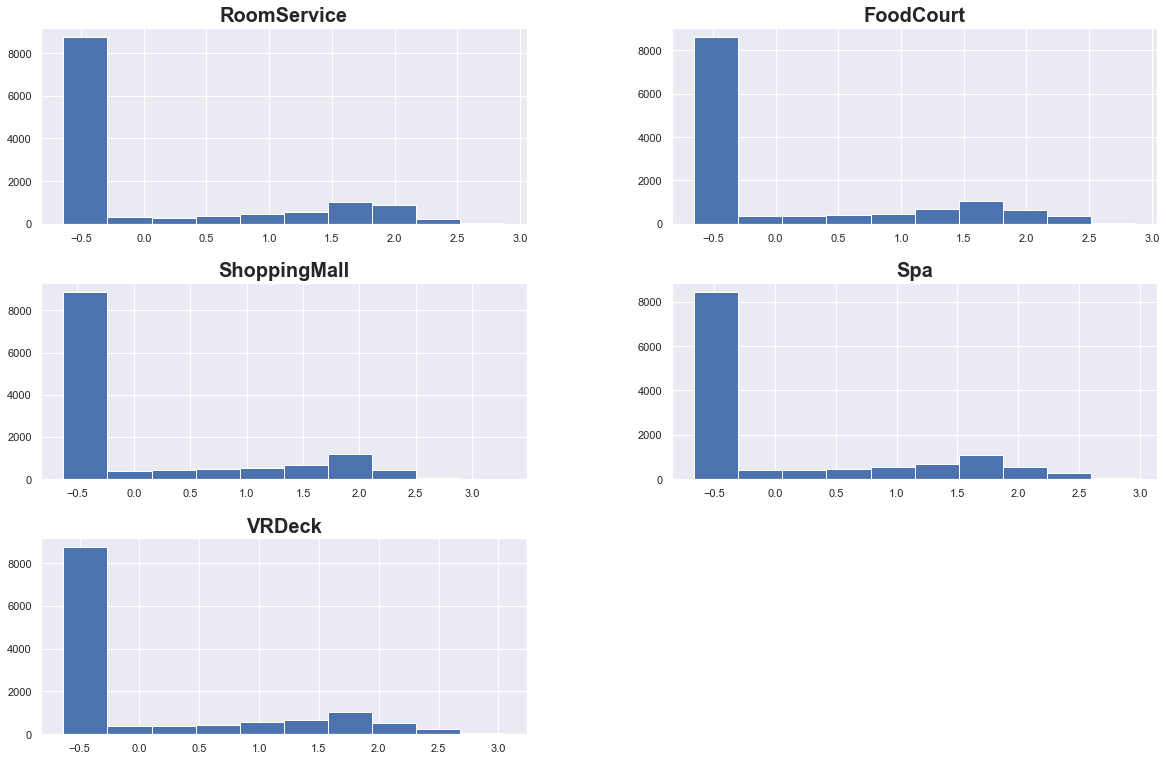

In [432]:
df[log_cols].hist(figsize=(20, 13));

## Scaling

In [416]:
df.drop(columns=[PID]).columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Target', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D',
       'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e'],
      dtype='object')

In [417]:
scale_cols = df.drop(columns=[PID, TARGET]).columns

In [418]:
scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])
df[scale_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
CryoSleep,12970.0,3.889633e-17,1.000039,-0.755128,-0.755128,-0.755128,1.324279,1.324279
Age,12970.0,-4.163550e-17,1.000039,-1.551098,-0.633694,0.283709,0.283709,3.035919
VIP,12970.0,8.765369e-18,1.000039,-0.160571,-0.160571,-0.160571,-0.160571,6.227783
RoomService,12970.0,-1.657203e-16,1.000039,-0.640372,-0.640372,-0.640372,0.747790,2.875540
FoodCourt,12970.0,-1.224413e-16,1.000039,-0.648903,-0.648903,-0.648903,0.769051,2.867100
ShoppingMall,12970.0,-4.492252e-17,1.000039,-0.624889,-0.624889,-0.624889,0.610158,3.286332
Spa,12970.0,1.533940e-17,1.000039,-0.663234,-0.663234,-0.663234,0.759680,2.961963
VRDeck,12970.0,3.396581e-17,1.000039,-0.634810,-0.634810,-0.634810,0.683749,3.050148
HomePlanet_Earth,12970.0,1.194282e-16,1.000039,-1.066509,-1.066509,0.937638,0.937638,0.937638
HomePlanet_Europa,12970.0,-5.259221e-17,1.000039,-0.588450,-0.588450,-0.588450,1.699379,1.699379


## Split Train-Test-Data

In [419]:
df_train = df[~df[TARGET].isna()].drop(columns=[PID])
df_test = df[df[TARGET].isna()].drop(columns=[TARGET])

display(
    (df_train.shape, df_test.shape),
    df_train.head(2),
    df_test.head(2)
)

((8693, 23), (4277, 23))

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Target,HomePlanet_Earth,...,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,-0.755128,0.283709,-0.160571,-0.640372,-0.648903,-0.624889,-0.663234,-0.634810,0.0,-1.066509,...,3.163888,-0.309531,-0.244391,-0.339157,-0.709275,-0.652491,-0.029135,-0.505656,-0.316951,0.646731
1,-0.755128,-0.633694,-0.160571,1.086538,0.136898,0.641264,1.620304,0.755227,1.0,0.937638,...,-0.316067,-0.309531,-0.244391,-0.339157,1.409890,-0.652491,-0.029135,-0.505656,-0.316951,0.646731


,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,...,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0013_01,1.324279,0.283709,-0.160571,-0.640372,-0.648903,-0.624889,-0.663234,-0.63481,0.937638,...,-0.316067,-0.309531,-0.244391,-0.339157,-0.709275,1.532588,-0.029135,-0.505656,-0.316951,0.646731
1,0018_01,-0.755128,-0.633694,-0.160571,-0.640372,0.136898,-0.624889,2.212364,-0.63481,0.937638,...,-0.316067,-0.309531,-0.244391,-0.339157,1.409890,-0.652491,-0.029135,-0.505656,-0.316951,0.646731


## Over Sampling the data

In [420]:
df_train[TARGET].value_counts()

1.0    4378
0.0    4315
Name: Target, dtype: int64

In [421]:
df_ex_target = df_train.drop(columns=[TARGET])
train_df_names = df_ex_target.columns

In [422]:
inputs = df_ex_target.to_numpy()
targets = df_train[TARGET].to_numpy()

inputs.shape, targets.shape

((8693, 22), (8693,))

In [423]:
bsmote = BorderlineSMOTE(random_state=101)
inputs, targets = bsmote.fit_resample(inputs, targets)

inputs.shape, targets.shape

((8756, 22), (8756,))

In [424]:
tmp_df = DataFrame(data=np.hstack([inputs, targets.reshape(-1, 1)]), columns=np.hstack([train_df_names, TARGET]))
tmp_df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Target
0,-0.755128,0.283709,-0.160571,-0.640372,-0.648903,-0.624889,-0.663234,-0.634810,-1.066509,1.699379,...,-0.309531,-0.244391,-0.339157,-0.709275,-0.652491,-0.029135,-0.505656,-0.316951,0.646731,0.0
1,-0.755128,-0.633694,-0.160571,1.086538,0.136898,0.641264,1.620304,0.755227,0.937638,-0.588450,...,-0.309531,-0.244391,-0.339157,1.409890,-0.652491,-0.029135,-0.505656,-0.316951,0.646731,1.0
2,-0.755128,2.118516,6.227783,0.749902,2.143455,-0.624889,2.525889,0.793700,-1.066509,1.699379,...,-0.309531,-0.244391,-0.339157,-0.709275,-0.652491,-0.029135,-0.505656,-0.316951,0.646731,0.0
3,-0.755128,0.283709,-0.160571,-0.640372,1.793810,1.675295,2.272011,1.288796,-1.066509,1.699379,...,-0.309531,-0.244391,-0.339157,-0.709275,-0.652491,-0.029135,-0.505656,-0.316951,0.646731,0.0
4,-0.755128,-0.633694,-0.160571,1.460007,0.805817,1.327477,1.630682,-0.233642,0.937638,-0.588450,...,-0.309531,-0.244391,-0.339157,1.409890,-0.652491,-0.029135,-0.505656,-0.316951,0.646731,1.0


In [425]:
tmp_df[TARGET].value_counts()

0.0    4378
1.0    4378
Name: Target, dtype: int64

# Data Export

In [426]:
df_test.to_csv("../model_data/submission_test_data.csv", index=False)

In [427]:
np.savez("../model_data/titanic_spaceship_prep_data", inputs=inputs, targets=targets, input_column_names=train_df_names)

In [428]:
test_load = np.load("../model_data/titanic_spaceship_prep_data.npz", allow_pickle=True)
test_load["inputs"].shape, test_load["targets"].shape, test_load["input_column_names"]

((8756, 22),
 (8756,),
 array(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt',
        'ShoppingMall', 'Spa', 'VRDeck', 'HomePlanet_Earth',
        'HomePlanet_Europa', 'HomePlanet_Mars', 'Cabin_A', 'Cabin_B',
        'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T',
        'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
        'Destination_TRAPPIST-1e'], dtype=object))